### External Imports

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!pip install stable-baselines[mpi] > /dev/null 2>&1
!pip install tensorflow==1.15 > /dev/null 2>&1

In [54]:
!rm -rf hc-environment/
! git clone https://gitlab.gwdg.de/kimsarah.meier/hc-environment.git > /dev/null 2>&1
! cd hc-environment
! pip install -e hc-environment > /dev/null 2>&1
exit()

### Imports

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import gym
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common import make_vec_env
from stable_baselines import PPO2
from stable_baselines.bench.monitor import Monitor
from stable_baselines.common.callbacks import EvalCallback
from stable_baselines.common.vec_env import DummyVecEnv, VecNormalize

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import csv
import math
import sys
import operator
import collections
import random
import os

from gym_honeycomb.common import DummySimulation, SimpleSimulation, plot_training_results
from gym_honeycomb.common import emp_utils, sim_utils, plots_utils

import numpy.random
numpy.random.seed(2021)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# MA Simulation: last best model

Custom policy directory

In [ ]:
policy_dir_list = ['/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_518/best_model_st19200000.zip',
                   '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_321/best_model_st19200000.zip',
                   '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_7373/best_model_st19200000.zip',
                   '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_601/best_model_st19200000.zip',
                   '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_3639/best_model_st19200000.zip',
                   '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_307/best_model_st19200000.zip',
                   '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_4444/best_model_st19200000.zip',
                   '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_12/best_model_st19200000.zip',
                   '/content/drive/MyDrive/HC/SB_FINAL3/Min/min_step6000_oep5_mb200_23456/best_model_st19200000.zip',
                   '/content/drive/MyDrive/HC/SB_FINAL3/Min/min_step6000_oep5_mb200_342/best_model_st17600000.zip'               
]


In [ ]:
policy_dir_list

['/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_518/best_model_st19200000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_321/best_model_st19200000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_7373/best_model_st19200000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_601/best_model_st19200000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_3639/best_model_st19200000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_307/best_model_st19200000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_4444/best_model_st19200000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_12/best_model_st19200000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Min/min_step6000_oep5_mb200_23456/best_model_st19200000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Min/min_step6000_oep5_mb200_342/best_model_st17600000.zip']

In [ ]:
ma_sim = SimpleSimulation()
df_move, df_eval, df_check = ma_sim.multi_agent_simulation(agents=policy_dir_list,
                                                      num_sim=5000, num_step=600,
                                                      shuffle=False,
                                                      deterministic=False)


 ------------ Start MA Simulation ------------
Load agents...

 ------ Start 5000 Simulations ------
0 Games over! Average Reward= 13.0
100 Games over! Average Reward= 13.727722772277227
200 Games over! Average Reward= 13.82587064676617
300 Games over! Average Reward= 13.953488372093023
400 Games over! Average Reward= 13.820448877805486
500 Games over! Average Reward= 13.811377245508982
600 Games over! Average Reward= 13.821963394342761
700 Games over! Average Reward= 13.858059914407988
800 Games over! Average Reward= 13.845193508114857
900 Games over! Average Reward= 13.824639289678135
1000 Games over! Average Reward= 13.803196803196803
1100 Games over! Average Reward= 13.76930063578565
1200 Games over! Average Reward= 13.767277268942548
1300 Games over! Average Reward= 13.776325903151422
1400 Games over! Average Reward= 13.805852962169878
1500 Games over! Average Reward= 13.786808794137242
1600 Games over! Average Reward= 13.792317301686445
1700 Games over! Average Reward= 13.773074

## Check dataframes

### Check df

In [ ]:
ma_sim.check_end_position

sim  agent      0      1  ...     57     58     59     60
end_position                              ...                            
(0, 3)        14705  14705  14705  14705  ...  13161  13137  13129  13109
(1, 1)           14     14     14     14  ...     14     14     14     14
(1, 2)         1925   1925   1925   1925  ...   1925   1925   1925   1925
(1, 3)           35     35     35     35  ...     35     35     35     35
(1, 4)         1873   1873   1873   1873  ...   1873   1873   1873   1873
(1, 5)         1445   1445   1445   1445  ...   1445   1445   1445   1445
(2, 1)            7      7      7      7  ...      7      7      7      7
(2, 3)            2      2      2      2  ...      2      2      2      2
(2, 6)            1      1      1      1  ...      1      1      1      1
(3, 0)         9794   9794   9794   9794  ...   9022   9010   9006   8996
(3, 1)           24     24     24     24  ...     24     24     24     24
(4, 1)           31     31     31     31  ...     31     31     31     31
(5, 1)          144    144    144    144  ...    144    144    144    144
(6, 1)           24     24     24     24  ...     24     24     24     24
(7, 2)         1687   1687   1687   1687  ...   1687   1687   1687   1687
(8, 3)           12     12     12     12  ...     12     12     12     12
(9, 3)        14873  14873  14873  14873  ...  13329  13305  13297  13277
(9, 4)           20     20     20     20  ...     20     20     20     20
(10, 5)        3356   3356   3356   3356  ...   3356   3356   3356   3356
(11, 6)          28     28     28     28  ...     28     28     28     28

[20 rows x 63 columns]

### Eval df

In [ ]:
ma_sim.eval_summary

sim           id  ...      arrivals         moves
count  50000.000000  50000.00000  ...  50000.000000  50000.000000
mean    2499.500000      4.50000  ...      2.974600      6.572640
std     1443.390078      2.87231  ...      0.652965      1.918447
min        0.000000      0.00000  ...      1.000000      5.000000
25%     1249.750000      2.00000  ...      3.000000      6.000000
50%     2499.500000      4.50000  ...      3.000000      6.000000
75%     3749.250000      7.00000  ...      3.000000      6.000000
max     4999.000000      9.00000  ...      4.000000     14.000000

[8 rows x 8 columns]

In [ ]:
ma_sim.df_eval.groupby('moves').size()

moves
5      7466
6     34522
7       386
8      2035
9       138
10      469
11     1692
12     2174
13     1096
14       22
dtype: int64

In [ ]:
print('%s agents have not arrived on a payoff field.' %ma_sim.df_eval[ma_sim.df_eval['reward']==0].shape[0])

10628 agents have not arrived on a payoff field.


### Move df

In [ ]:
ma_sim.df_move.describe()

sim           turn  ...             s1             s2
count  328632.000000  328632.000000  ...  328632.000000  328632.000000
mean     2499.835001      47.668246  ...       5.192550       3.867785
std      1443.333338      65.525120  ...       2.753435       1.463409
min         0.000000       1.000000  ...       0.000000       0.000000
25%      1250.000000      17.000000  ...       3.000000       3.000000
50%      2500.000000      33.000000  ...       5.000000       4.000000
75%      3750.000000      50.000000  ...       8.000000       5.000000
max      4999.000000     599.000000  ...      11.000000       8.000000

[8 rows x 6 columns]

## Viz

In [ ]:
output_path = '/content/drive/MyDrive/HC/Sim5000/last_best_model'
ma_sim.save_results(path=output_path)

Saved dataframes in folder: /content/drive/MyDrive/HC/Sim5000/last_best_model


In [ ]:
# ANPASSEN
moves_path = output_path + '/sim_train_move.csv'
eval_path = output_path + '/sim_train_eval.csv'

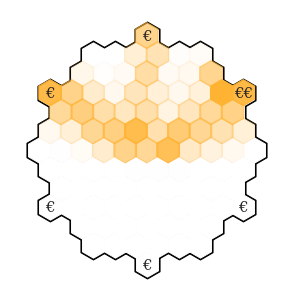

In [ ]:
colors, map = sim_utils.get_sim_freq(path_movescsv=moves_path)
plots_utils.make_freq_plot(rgba_colors=colors, mapmap = map, plotname = 'sim_freqplot', output_path=output_path)

### Other plots

In [ ]:
# get data
emp_df, emp_group_arrival = emp_utils.get_empdata_for_comparisons()
sim_df, sim_group_arrival = sim_utils.get_simdata_for_comparisons(evalcsv_path=eval_path, movecsv_path=moves_path)

# merge
df = plots_utils.merge_sim_emp_data_for_comparisons(sim_data = sim_df, emp_data = emp_df)

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


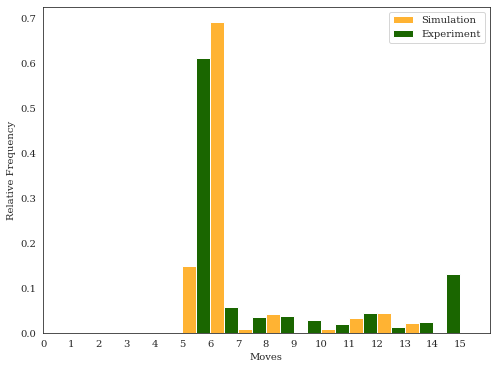

In [ ]:
plots_utils.plot_amount_of_moves(df = df, output_path = output_path)

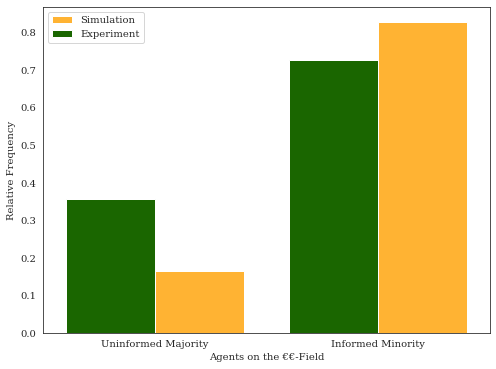

In [ ]:
plots_utils.plot_arrived_special_payoff(df = df, output_path = output_path) 

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


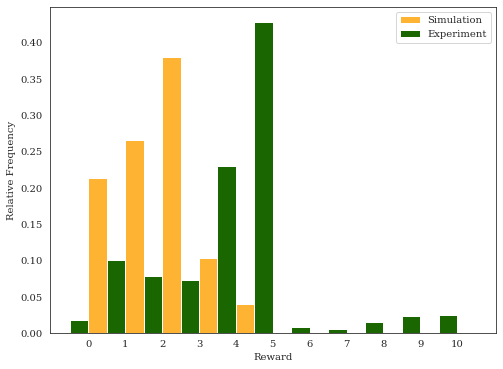

In [ ]:
plots_utils.plot_freq_of_rewards(df = df, output_path = output_path)

0


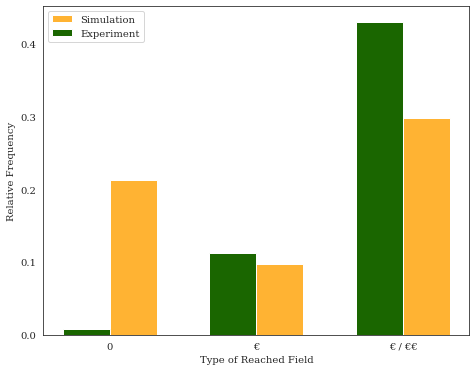

In [ ]:
plots_utils.plot_rel_freq_type_of_field(df = df, output_path = output_path)

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


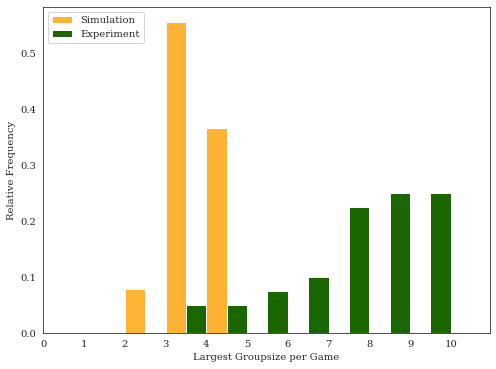

In [ ]:
plots_utils.plot_freq_of_grouparrivalsizes(sim_group_arrival, emp_group_arrival, output_path=output_path)

# MA Simulation: 14e6

Policy saved at same training step

In [ ]:
policy_dir_list = []
policy_seeds_maj = [518, 321, 7373, 601, 3639, 307, 4444, 12]
policy_seeds_min = [23456, 342]
for s in policy_seeds_maj:
  policy_dir_list.append('/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_' 
                         +str(s) + '/checkpoints/maj_step6000_oep5_mb200_' +str(s) + '_14000000_steps.zip')
  #policy_dir_list.append('/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_' 
  #                       +str(s) + '/best_model.zip')

for s in policy_seeds_min:
  policy_dir_list.append('/content/drive/MyDrive/HC/SB_FINAL3/Min/min_step6000_oep5_mb200_' 
                         +str(s) + '/checkpoints/min_step6000_oep5_mb200_' +str(s) + '_14000000_steps.zip')
  #policy_dir_list.append('/content/drive/MyDrive/HC/SB_FINAL3/Min/min_step6000_oep5_mb200_' 
  #                       +str(s) + '/best_model.zip')

sim_nr = 200
print('Use policies with seeds:', policy_seeds_maj + policy_seeds_min)

Use policies with seeds: [518, 321, 7373, 601, 3639, 307, 4444, 12, 23456, 342]


In [ ]:
policy_dir_list

['/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_518/checkpoints/maj_step6000_oep5_mb200_518_14000000_steps.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_321/checkpoints/maj_step6000_oep5_mb200_321_14000000_steps.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_7373/checkpoints/maj_step6000_oep5_mb200_7373_14000000_steps.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_601/checkpoints/maj_step6000_oep5_mb200_601_14000000_steps.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_3639/checkpoints/maj_step6000_oep5_mb200_3639_14000000_steps.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_307/checkpoints/maj_step6000_oep5_mb200_307_14000000_steps.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_4444/checkpoints/maj_step6000_oep5_mb200_4444_14000000_steps.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_12/checkpoi

In [ ]:
ma_sim = SimpleSimulation()
df_move, df_eval, df_check = ma_sim.multi_agent_simulation(agents=policy_dir_list,
                                                        num_sim=5000, num_step=600,
                                                        shuffle=True,
                                                        deterministic=False)


 ------------ Start MA Simulation ------------
Load agents...





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




 ------ Start 5000 Simulations ------
0 Games over! Average Reward= 8.5
100 Games over! Average Reward= 13.678217821782178
200 Games over! Average Reward= 14.057213930348258
300 Games over! Average Reward= 13.92358803986711
400 Games over! Average Reward= 13.908977556109726
500 Games over! Average Reward= 13.828343313373253
600 Games over! Average Reward= 13.942595673876871
700 Games over! Average Reward= 13.963623395149787
800 Games over! Average Reward= 13.953807740324594
900 Games over! Average Reward= 14.004439511653718
1000 Games over! Average Reward= 13.983516483516484
1100 Games over! Average Reward= 14.004995458673934
1200 Games over! Average Reward= 13.963780183180683
1300 Games 

## Check dataframes

### Check df

In [ ]:
ma_sim.check_end_position

sim  agent      0      1      2  ...  73  74  75  76  77
end_position                                     ...                    
(0, 3)        12704  12704  12704  12704  12704  ...  36  16  11   8   3
(1, 1)          138    138    138    138    138  ...   0   0   0   0   0
(1, 2)         3396   3396   3396   3396   3396  ...   4   3   2   2   0
(1, 3)         1876   1876   1876   1876   1876  ...  14   5   2   1   1
(1, 4)          505    505    505    505    505  ...   3   1   0   0   0
(1, 5)          410    410    410    410    410  ...   2   1   0   0   0
(1, 6)           58     58     58     58     58  ...   2   1   0   0   0
(2, 1)          317    317    317    317    317  ...   1   0   0   0   0
(2, 2)          415    415    415    415    415  ...   1   0   0   0   0
(2, 3)          353    353    353    353    353  ...   2   1   1   1   0
(2, 4)           92     92     92     92     92  ...   0   0   0   0   0
(2, 5)            5      5      5      5      5  ...   0   0   0   0   0
(2, 6)            2      2      2      2      2  ...   0   0   0   0   0
(3, 0)         9559   9559   9559   9559   9559  ...  30  14   8   6   2
(3, 1)           63     63     63     63     63  ...   1   0   0   0   0
(3, 3)            2      2      2      2      2  ...   0   0   0   0   0
(3, 4)            5      5      5      5      5  ...   0   0   0   0   0
(4, 1)           16     16     16     16     16  ...   0   0   0   0   0
(5, 1)           84     84     84     84     84  ...   0   0   0   0   0
(6, 1)            7      7      7      7      7  ...   0   0   0   0   0
(6, 2)            3      3      3      3      3  ...   0   0   0   0   0
(7, 2)          594    594    594    594    594  ...   0   0   0   0   0
(7, 3)            3      3      3      3      3  ...   0   0   0   0   0
(8, 3)          974    974    974    974    974  ...   7   2   2   0   0
(8, 4)            3      3      3      3      3  ...   1   0   0   0   0
(9, 3)        16473  16473  16473  16473  16473  ...  49  23  12  10   4
(9, 4)          126    126    126    126    126  ...   0   0   0   0   0
(10, 5)        1800   1800   1800   1800   1800  ...   7   3   2   2   0
(11, 6)          17     17     17     17     17  ...   0   0   0   0   0

[29 rows x 80 columns]

### Eval df

In [ ]:
ma_sim.eval_summary

sim           id  ...      arrivals         moves
count  50000.000000  50000.00000  ...  50000.000000  50000.000000
mean    2499.500000      4.50000  ...      3.294600      8.564580
std     1443.390078      2.87231  ...      0.743385      3.716141
min        0.000000      0.00000  ...      0.000000      5.000000
25%     1249.750000      2.00000  ...      3.000000      6.000000
50%     2499.500000      4.50000  ...      3.000000      6.000000
75%     3749.250000      7.00000  ...      4.000000     13.000000
max     4999.000000      9.00000  ...      4.000000     15.000000

[8 rows x 8 columns]

In [ ]:
ma_sim.df_eval.groupby('moves').size()

moves
5      4736
6     24708
7      1036
8      2815
9       415
10     1090
11      646
12     1761
13     2701
14     2837
15     7255
dtype: int64

In [ ]:
print('%s agents have not arrived on a payoff field.' %ma_sim.df_eval[ma_sim.df_eval['reward']==0].shape[0])

11264 agents have not arrived on a payoff field.


### Move df

In [ ]:
ma_sim.df_move.describe()

sim           turn  ...             s1             s2
count  428229.000000  428229.000000  ...  428229.000000  428229.000000
mean     2500.453956      65.974721  ...       4.792777       3.540297
std      1442.665050      79.432869  ...       2.882804       1.499638
min         0.000000       1.000000  ...       0.000000       0.000000
25%      1252.000000      22.000000  ...       2.000000       3.000000
50%      2500.000000      43.000000  ...       4.000000       4.000000
75%      3749.000000      84.000000  ...       8.000000       5.000000
max      4999.000000     600.000000  ...      11.000000       9.000000

[8 rows x 6 columns]

## Viz

In [ ]:
output_path = '/content/drive/MyDrive/HC/Sim5000/14e6_model'
ma_sim.save_results(path=output_path)

Saved dataframes in folder: /content/drive/MyDrive/HC/Sim5000/14e6_model


In [ ]:
# ANPASSEN
moves_path = output_path + '/sim_train_move.csv'
eval_path = output_path + '/sim_train_eval.csv'

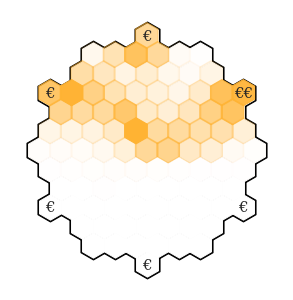

In [ ]:
colors, map = sim_utils.get_sim_freq(path_movescsv=moves_path)
plots_utils.make_freq_plot(rgba_colors=colors, mapmap = map, plotname = 'sim_freqplot', output_path=output_path)

### Other plots

In [ ]:
# get data
emp_df, emp_group_arrival = emp_utils.get_empdata_for_comparisons()
sim_df, sim_group_arrival = sim_utils.get_simdata_for_comparisons(evalcsv_path=eval_path, movecsv_path=moves_path)

# merge
df = plots_utils.merge_sim_emp_data_for_comparisons(sim_data = sim_df, emp_data = emp_df)

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


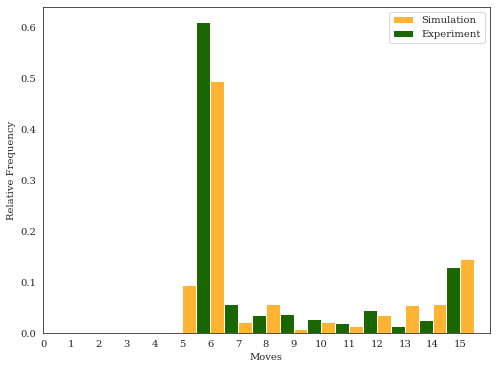

In [ ]:
plots_utils.plot_amount_of_moves(df = df, output_path = output_path)

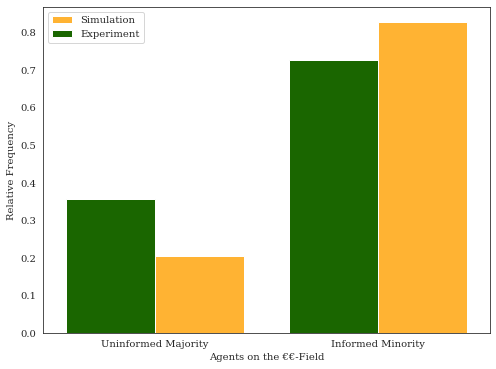

In [ ]:
plots_utils.plot_arrived_special_payoff(df = df, output_path = output_path) 

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


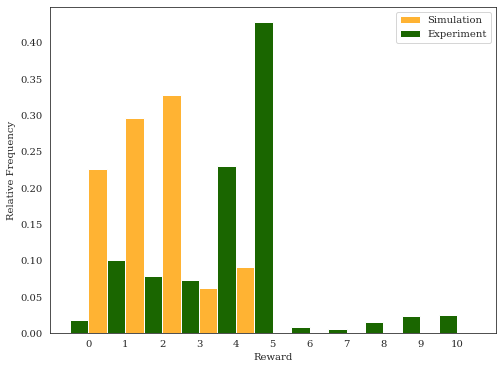

In [ ]:
plots_utils.plot_freq_of_rewards(df = df, output_path = output_path)

0


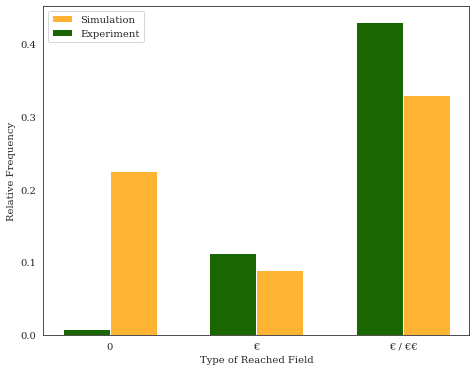

In [ ]:
plots_utils.plot_rel_freq_type_of_field(df = df, output_path = output_path)

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


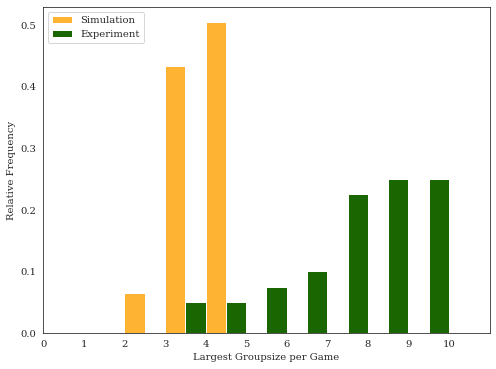

In [ ]:
plots_utils.plot_freq_of_grouparrivalsizes(sim_group_arrival, emp_group_arrival, output_path=output_path)

# MA Simulation: 10e6

Policy saved at same training step

In [ ]:
policy_dir_list = []
policy_seeds_maj = [518, 321, 7373, 601, 3639, 307, 4444, 12]
policy_seeds_min = [23456, 342]
for s in policy_seeds_maj:
  policy_dir_list.append('/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_' 
                         +str(s) + '/checkpoints/maj_step6000_oep5_mb200_' +str(s) + '_10000000_steps.zip')
  #policy_dir_list.append('/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_' 
  #                       +str(s) + '/best_model.zip')

for s in policy_seeds_min:
  policy_dir_list.append('/content/drive/MyDrive/HC/SB_FINAL3/Min/min_step6000_oep5_mb200_' 
                         +str(s) + '/checkpoints/min_step6000_oep5_mb200_' +str(s) + '_10000000_steps.zip')
  #policy_dir_list.append('/content/drive/MyDrive/HC/SB_FINAL3/Min/min_step6000_oep5_mb200_' 
  #                       +str(s) + '/best_model.zip')

sim_nr = 200
print('Use policies with seeds:', policy_seeds_maj + policy_seeds_min)

Use policies with seeds: [518, 321, 7373, 601, 3639, 307, 4444, 12, 23456, 342]


In [ ]:
policy_dir_list

['/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_518/checkpoints/maj_step6000_oep5_mb200_518_10000000_steps.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_321/checkpoints/maj_step6000_oep5_mb200_321_10000000_steps.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_7373/checkpoints/maj_step6000_oep5_mb200_7373_10000000_steps.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_601/checkpoints/maj_step6000_oep5_mb200_601_10000000_steps.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_3639/checkpoints/maj_step6000_oep5_mb200_3639_10000000_steps.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_307/checkpoints/maj_step6000_oep5_mb200_307_10000000_steps.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_4444/checkpoints/maj_step6000_oep5_mb200_4444_10000000_steps.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_12/checkpoi

In [ ]:
ma_sim = SimpleSimulation()
df_move, df_eval, df_check = ma_sim.multi_agent_simulation(agents=policy_dir_list,
                                                      num_sim=5000, num_step=1000,
                                                      shuffle=True,
                                                      deterministic=False)


 ------------ Start MA Simulation ------------
Load agents...

 ------ Start 5000 Simulations ------
0 Games over! Average Reward= 7.0
100 Games over! Average Reward= 7.900990099009901
200 Games over! Average Reward= 7.681592039800995
300 Games over! Average Reward= 7.8887043189368775
400 Games over! Average Reward= 7.945137157107232
500 Games over! Average Reward= 7.955089820359281
600 Games over! Average Reward= 7.9209650582362725
700 Games over! Average Reward= 7.970756062767475
800 Games over! Average Reward= 7.930087390761548
900 Games over! Average Reward= 7.94062153163152
1000 Games over! Average Reward= 7.878621378621379
1100 Games over! Average Reward= 7.826067211625794
1200 Games over! Average Reward= 7.819317235636969
1300 Games over! Average Reward= 7.805918524212145
1400 Games over! Average Reward= 7.805496074232691
1500 Games over! Average Reward= 7.813124583610926
1600 Games over! Average Reward= 7.79575265459088
1700 Games over! Average Reward= 7.820987654320987
1800 G

## Check dataframes

### Check df

In [ ]:
ma_sim.check_end_position

sim  agent      0      1      2  ...  138  139  140  141  142
end_position                                     ...                         
(0, 3)         8020   8020   8020   8020   8020  ...    1    1    1    1    1
(1, 1)          595    595    595    595    595  ...    1    1    0    0    0
(1, 2)         2017   2017   2017   2017   2017  ...    0    0    0    0    0
(1, 3)         4004   4004   4004   4004   4004  ...    3    3    2    2    2
(1, 4)         4105   4105   4105   4105   4105  ...    3    3    1    1    1
(1, 5)          326    326    326    326    326  ...    0    0    0    0    0
(1, 6)           36     36     36     36     36  ...    0    0    0    0    0
(2, 1)          203    203    203    203    203  ...    0    0    0    0    0
(2, 2)          250    250    250    250    250  ...    0    0    0    0    0
(2, 3)          228    228    228    228    228  ...    0    0    0    0    0
(2, 4)          141    141    141    141    141  ...    0    0    0    0    0
(2, 5)           57     57     57     57     57  ...    0    0    0    0    0
(2, 6)           50     50     50     50     50  ...    0    0    0    0    0
(2, 7)            7      7      7      7      7  ...    0    0    0    0    0
(3, 0)         9381   9381   9381   9381   9381  ...    4    4    2    2    2
(3, 1)          254    254    254    254    254  ...    0    0    0    0    0
(3, 2)           13     13     13     13     13  ...    0    0    0    0    0
(3, 3)           18     18     18     18     18  ...    0    0    0    0    0
(3, 4)           14     14     14     14     14  ...    0    0    0    0    0
(3, 5)            4      4      4      4      4  ...    0    0    0    0    0
(3, 6)            9      9      9      9      9  ...    0    0    0    0    0
(3, 7)            3      3      3      3      3  ...    0    0    0    0    0
(4, 1)          170    170    170    170    170  ...    0    0    0    0    0
(4, 2)            4      4      4      4      4  ...    0    0    0    0    0
(4, 6)            1      1      1      1      1  ...    0    0    0    0    0
(5, 1)          141    141    141    141    141  ...    0    0    0    0    0
(5, 2)           55     55     55     55     55  ...    0    0    0    0    0
(5, 3)            7      7      7      7      7  ...    0    0    0    0    0
(5, 4)            1      1      1      1      1  ...    0    0    0    0    0
(6, 1)          209    209    209    209    209  ...    0    0    0    0    0
(6, 2)          327    327    327    327    327  ...    0    0    0    0    0
(6, 3)          105    105    105    105    105  ...    0    0    0    0    0
(6, 4)            9      9      9      9      9  ...    0    0    0    0    0
(7, 2)         1636   1636   1636   1636   1636  ...    2    2    2    2    2
(7, 3)          573    573    573    573    573  ...    0    0    0    0    0
(7, 4)           85     85     85     85     85  ...    0    0    0    0    0
(7, 5)           12     12     12     12     12  ...    0    0    0    0    0
(8, 3)         2156   2156   2156   2156   2156  ...    1    1    1    1    1
(8, 4)          324    324    324    324    324  ...    0    0    0    0    0
(8, 5)           17     17     17     17     17  ...    0    0    0    0    0
(8, 6)            1      1      1      1      1  ...    0    0    0    0    0
(9, 3)        11882  11882  11882  11882  11882  ...    4    4    1    1    1
(9, 4)          573    573    573    573    573  ...    0    0    0    0    0
(9, 5)           80     80     80     80     80  ...    1    1    0    0    0
(9, 6)            2      2      2      2      2  ...    0    0    0    0    0
(10, 5)        1857   1857   1857   1857   1857  ...    0    0    0    0    0
(10, 6)           3      3      3      3      3  ...    0    0    0    0    0
(11, 6)          35     35     35     35     35  ...    0    0    0    0    0

[48 rows x 145 columns]

### Eval df

In [ ]:
ma_sim.eval_summary

sim           id  ...      arrivals         moves
count  50000.000000  50000.00000  ...  50000.000000  50000.000000
mean    2499.500000      4.50000  ...      2.376400     11.334440
std     1443.390078      2.87231  ...      0.848727      4.101771
min        0.000000      0.00000  ...      0.000000      5.000000
25%     1249.750000      2.00000  ...      2.000000      6.000000
50%     2499.500000      4.50000  ...      2.000000     14.000000
75%     3749.250000      7.00000  ...      3.000000     15.000000
max     4999.000000      9.00000  ...      4.000000     15.000000

[8 rows x 8 columns]

In [ ]:
ma_sim.df_eval.groupby('moves').size()

moves
5      2869
6     12391
7       502
8      2233
9       307
10     1577
11      354
12     1304
13     2333
14     3701
15    22429
dtype: int64

In [ ]:
print('%s agents have not arrived on a payoff field.' %ma_sim.df_eval[ma_sim.df_eval['reward']==0].shape[0])

20717 agents have not arrived on a payoff field.


### Move df

In [ ]:
ma_sim.df_move.describe()

sim           turn  ...             s1             s2
count  566722.000000  566722.000000  ...  566722.000000  566722.000000
mean     2499.250213     103.105847  ...       4.257821       3.449924
std      1443.176909     114.304505  ...       2.841958       1.535758
min         0.000000       1.000000  ...       0.000000       0.000000
25%      1250.000000      29.000000  ...       2.000000       3.000000
50%      2499.000000      61.000000  ...       4.000000       3.000000
75%      3750.000000     130.000000  ...       7.000000       5.000000
max      4999.000000     600.000000  ...      12.000000      11.000000

[8 rows x 6 columns]

## Viz

In [ ]:
output_path = '/content/drive/MyDrive/HC/Sim5000/10e6_model'
ma_sim.save_results(path=output_path)

In [ ]:
# ANPASSEN
moves_path = output_path + '/sim_train_move.csv'
eval_path = output_path + '/sim_train_eval.csv'

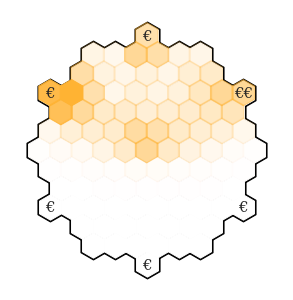

In [ ]:
colors, map = sim_utils.get_sim_freq(path_movescsv=moves_path)
plots_utils.make_freq_plot(rgba_colors=colors, mapmap = map, plotname = 'sim_freqplot', output_path=output_path)

### Other plots

In [ ]:
# get data
emp_df, emp_group_arrival = emp_utils.get_empdata_for_comparisons()
sim_df, sim_group_arrival = sim_utils.get_simdata_for_comparisons(evalcsv_path=eval_path, movecsv_path=moves_path)

# merge
df = plots_utils.merge_sim_emp_data_for_comparisons(sim_data = sim_df, emp_data = emp_df)

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


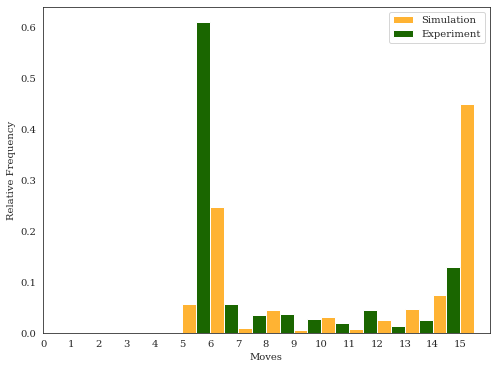

In [ ]:
plots_utils.plot_amount_of_moves(df = df, output_path = output_path)

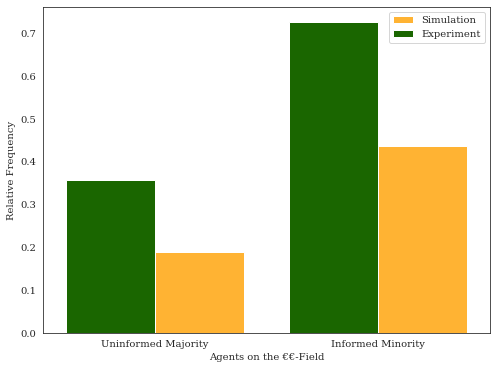

In [ ]:
plots_utils.plot_arrived_special_payoff(df = df, output_path = output_path) 

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


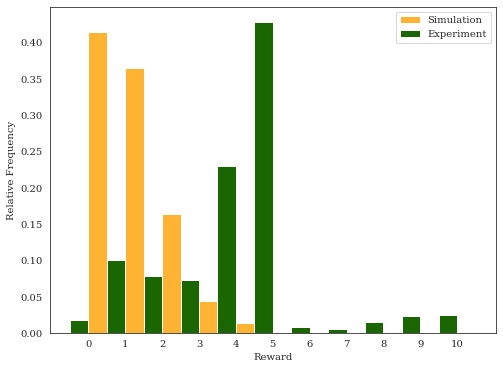

In [ ]:
plots_utils.plot_freq_of_rewards(df = df, output_path = output_path)

0


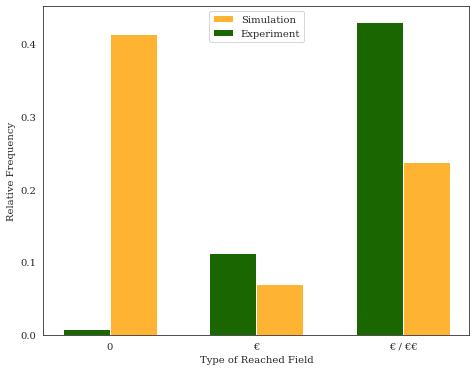

In [ ]:
plots_utils.plot_rel_freq_type_of_field(df = df, output_path = output_path)

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


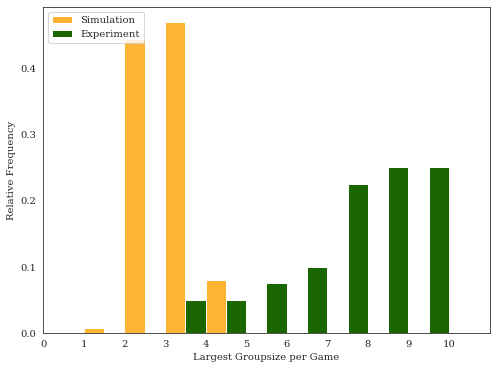

In [ ]:
plots_utils.plot_freq_of_grouparrivalsizes(sim_group_arrival, emp_group_arrival, output_path=output_path)

# MA Simulation: 16e6

Policy saved at same training step

In [36]:
policy_dir_list = []
policy_seeds_maj = [518, 321, 7373, 601, 3639, 307, 4444, 12]
policy_seeds_min = [23456, 342]
for s in policy_seeds_maj:
  policy_dir_list.append('/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_' 
                         +str(s) + '/checkpoints/maj_step6000_oep5_mb200_' +str(s) + '_16000000_steps.zip')

for s in policy_seeds_min:
  policy_dir_list.append('/content/drive/MyDrive/HC/SB_FINAL3/Min/min_step6000_oep5_mb200_' 
                         +str(s) + '/checkpoints/min_step6000_oep5_mb200_' +str(s) + '_16000000_steps.zip')

sim_nr = 200
print('Use policies with seeds:', policy_seeds_maj + policy_seeds_min)

Use policies with seeds: [518, 321, 7373, 601, 3639, 307, 4444, 12, 23456, 342]


In [37]:
policy_dir_list

['/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_518/checkpoints/maj_step6000_oep5_mb200_518_16000000_steps.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_321/checkpoints/maj_step6000_oep5_mb200_321_16000000_steps.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_7373/checkpoints/maj_step6000_oep5_mb200_7373_16000000_steps.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_601/checkpoints/maj_step6000_oep5_mb200_601_16000000_steps.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_3639/checkpoints/maj_step6000_oep5_mb200_3639_16000000_steps.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_307/checkpoints/maj_step6000_oep5_mb200_307_16000000_steps.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_4444/checkpoints/maj_step6000_oep5_mb200_4444_16000000_steps.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_12/checkpoi

In [39]:
ma_sim = SimpleSimulation()
df_move, df_eval, df_check = ma_sim.multi_agent_simulation(agents=policy_dir_list,
                                                      num_sim=5000, num_step=1000,
                                                      shuffle=True,
                                                      deterministic=False)


 ------------ Start MA Simulation ------------
Load agents...

 ------ Start 5000 Simulations ------
0 Games over! Average Reward= 14.5
100 Games over! Average Reward= 10.663366336633663
200 Games over! Average Reward= 10.813432835820896
300 Games over! Average Reward= 11.018272425249169
400 Games over! Average Reward= 11.251870324189527
500 Games over! Average Reward= 11.22754491017964
600 Games over! Average Reward= 11.176372712146422
700 Games over! Average Reward= 11.075606276747504
800 Games over! Average Reward= 11.143570536828964
900 Games over! Average Reward= 11.221975582685905
1000 Games over! Average Reward= 11.241258741258742
1100 Games over! Average Reward= 11.210263396911898
1200 Games over! Average Reward= 11.213988343047461
1300 Games over! Average Reward= 11.167563412759415
1400 Games over! Average Reward= 11.192005710206995
1500 Games over! Average Reward= 11.227514990006663
1600 Games over! Average Reward= 11.209244222361024
1700 Games over! Average Reward= 11.22075

## Check dataframes

### Check df

In [40]:
ma_sim.check_end_position

sim  agent      0      1      2  ...   74  75  76  77  78
end_position                                     ...                     
(0, 3)         7854   7854   7854   7854   7854  ...   29  14   8   2   0
(1, 1)          744    744    744    744    744  ...    7   3   1   1   1
(1, 2)         5823   5823   5823   5823   5823  ...   33  21   8   5   1
(1, 3)          632    632    632    632    632  ...   11   6   0   0   0
(1, 4)         3410   3410   3410   3410   3410  ...   36  21   6   3   1
(1, 5)         1218   1218   1218   1218   1218  ...    8   6   1   1   1
(1, 6)           43     43     43     43     43  ...    1   0   0   0   0
(2, 1)          526    526    526    526    526  ...    7   4   2   2   1
(2, 2)           80     80     80     80     80  ...    0   0   0   0   0
(2, 3)           43     43     43     43     43  ...    0   0   0   0   0
(2, 4)            3      3      3      3      3  ...    0   0   0   0   0
(2, 5)           15     15     15     15     15  ...    0   0   0   0   0
(2, 6)            2      2      2      2      2  ...    0   0   0   0   0
(2, 7)            2      2      2      2      2  ...    0   0   0   0   0
(3, 0)         9561   9561   9561   9561   9561  ...   60  33  10   4   1
(3, 1)           35     35     35     35     35  ...    0   0   0   0   0
(3, 2)            1      1      1      1      1  ...    0   0   0   0   0
(3, 4)            1      1      1      1      1  ...    0   0   0   0   0
(3, 6)            2      2      2      2      2  ...    0   0   0   0   0
(4, 1)            5      5      5      5      5  ...    0   0   0   0   0
(6, 1)          130    130    130    130    130  ...    0   0   0   0   0
(7, 2)         2786   2786   2786   2786   2786  ...    9   5   2   1   0
(8, 3)          649    649    649    649    649  ...    8   2   0   0   0
(8, 4)            2      2      2      2      2  ...    0   0   0   0   0
(9, 3)        15940  15940  15940  15940  15940  ...  106  61  20   9   4
(9, 4)           21     21     21     21     21  ...    1   1   1   1   0
(10, 5)         466    466    466    466    466  ...    4   3   1   1   0
(11, 6)           6      6      6      6      6  ...    0   0   0   0   0

[28 rows x 81 columns]

### Eval df

In [41]:
ma_sim.eval_summary

sim           id  ...      arrivals         moves
count  50000.000000  50000.00000  ...  50000.000000  50000.000000
mean    2499.500000      4.50000  ...      3.188000      8.121020
std     1443.390078      2.87231  ...      0.731756      3.484149
min        0.000000      0.00000  ...      0.000000      5.000000
25%     1249.750000      2.00000  ...      3.000000      6.000000
50%     2499.500000      4.50000  ...      3.000000      6.000000
75%     3749.250000      7.00000  ...      4.000000     11.000000
max     4999.000000      9.00000  ...      4.000000     15.000000

[8 rows x 8 columns]

In [42]:
ma_sim.df_eval.groupby('moves').size()

moves
5      8969
6     21769
7       883
8      1986
9      1633
10     2189
11     1240
12     1559
13     2290
14     2412
15     5070
dtype: int64

In [43]:
print('%s agents have not arrived on a payoff field.' %ma_sim.df_eval[ma_sim.df_eval['reward']==0].shape[0])

16645 agents have not arrived on a payoff field.


### Move df

In [44]:
ma_sim.df_move.describe()

sim           turn  ...             s1             s2
count  406051.000000  406051.000000  ...  406051.000000  406051.000000
mean     2501.029661      77.015530  ...       4.543599       3.439630
std      1442.574412     107.309172  ...       2.784821       1.401191
min         0.000000       1.000000  ...       0.000000       0.000000
25%      1253.000000      21.000000  ...       2.000000       3.000000
50%      2502.000000      41.000000  ...       4.000000       3.000000
75%      3749.000000      78.000000  ...       7.000000       4.000000
max      4999.000000     600.000000  ...      11.000000       8.000000

[8 rows x 6 columns]

## Viz

In [45]:
output_path = '/content/drive/MyDrive/HC/Sim5000/10e6_model'
ma_sim.save_results(path=output_path)

Saved dataframes in folder: /content/drive/MyDrive/HC/Sim5000/10e6_model


In [46]:
# ANPASSEN
moves_path = output_path + '/sim_train_move.csv'
eval_path = output_path + '/sim_train_eval.csv'

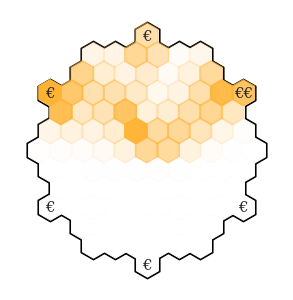

In [47]:
colors, map = sim_utils.get_sim_freq(path_movescsv=moves_path)
plots_utils.make_freq_plot(rgba_colors=colors, mapmap = map, plotname = 'sim_freqplot', output_path=output_path)

### Other plots

In [48]:
# get data
emp_df, emp_group_arrival = emp_utils.get_empdata_for_comparisons()
sim_df, sim_group_arrival = sim_utils.get_simdata_for_comparisons(evalcsv_path=eval_path, movecsv_path=moves_path)

# merge
df = plots_utils.merge_sim_emp_data_for_comparisons(sim_data = sim_df, emp_data = emp_df)

/content/hc-environment/gym_honeycomb/common/emp_utils.py:438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['reward'] = rewards
/content/hc-environment/gym_honeycomb/common/emp_utils.py:439: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['arrived'] = arriveds
/content/hc-environment/gym_honeycomb/common/emp_utils.py:438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


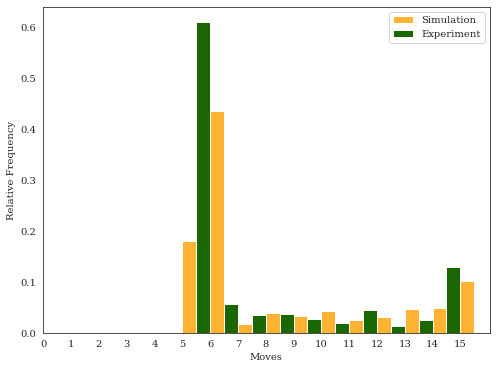

In [49]:
plots_utils.plot_amount_of_moves(df = df, output_path = output_path)

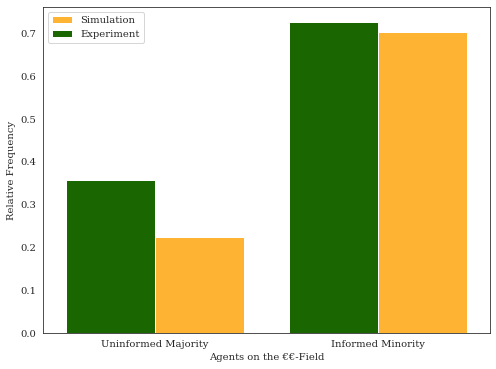

In [50]:
plots_utils.plot_arrived_special_payoff(df = df, output_path = output_path) 

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


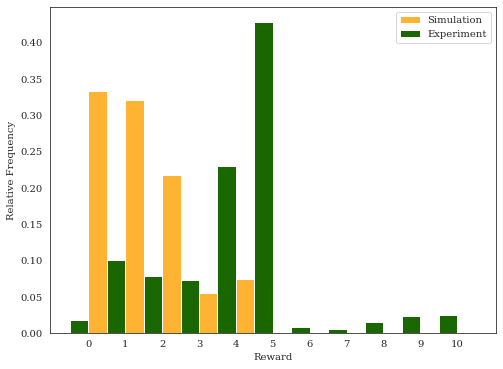

In [51]:
plots_utils.plot_freq_of_rewards(df = df, output_path = output_path)

0


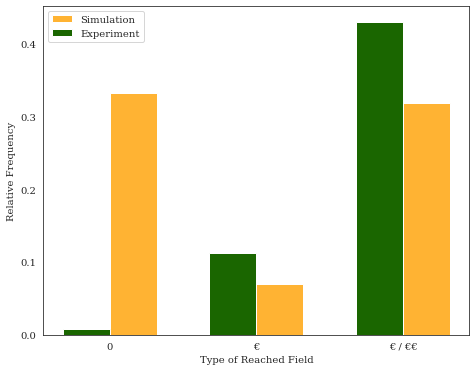

In [52]:
plots_utils.plot_rel_freq_type_of_field(df = df, output_path = output_path)

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


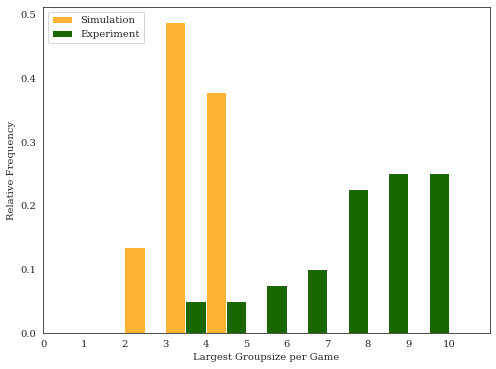

In [53]:
plots_utils.plot_freq_of_grouparrivalsizes(sim_group_arrival, emp_group_arrival, output_path=output_path)

# MA Simulation: best model 13.6e6

Policy saved at same training step

In [51]:
policy_dir_list = ['/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_12/best_model_st13600000.zip',
                   '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_307/best_model_st13600000.zip',
                   '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_321/best_model_st13600000.zip',
                   '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_3639/best_model_st13600000.zip',
                   '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_4444/best_model_st12000000.zip',
                   '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_518/best_model_st13600000.zip',
                   '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_7373/best_model_st13600000.zip',
                   '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_601/best_model_st13600000.zip',
                   '/content/drive/MyDrive/HC/SB_FINAL3/Min/min_step6000_oep5_mb200_23456/best_model_st13600000.zip',
                   '/content/drive/MyDrive/HC/SB_FINAL3/Min/min_step6000_oep5_mb200_342/best_model_st13600000.zip'
                         
]

In [52]:
policy_dir_list

['/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_12/best_model_st13600000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_307/best_model_st13600000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_321/best_model_st13600000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_3639/best_model_st13600000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_4444/best_model_st12000000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_518/best_model_st13600000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_7373/best_model_st13600000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_601/best_model_st13600000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Min/min_step6000_oep5_mb200_23456/best_model_st13600000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Min/min_step6000_oep5_mb200_342/best_model_st13600000.zip']

In [53]:
numpy.random.seed(2021)
ma_sim = SimpleSimulation()
df_move, df_eval, df_check = ma_sim.multi_agent_simulation(agents=policy_dir_list,
                                                      num_sim=5000, num_step=6000,
                                                      shuffle=True,
                                                      deterministic=False)


 ------------ Start MA Simulation ------------
Load agents...

 ------ Start 5000 Simulations ------
0 Games over! Average Reward= 17.5
100 Games over! Average Reward= 15.722772277227723
200 Games over! Average Reward= 15.542288557213931
300 Games over! Average Reward= 15.519933554817277
400 Games over! Average Reward= 15.428927680798004
500 Games over! Average Reward= 15.525948103792414
600 Games over! Average Reward= 15.419301164725457
700 Games over! Average Reward= 15.418687589158345
800 Games over! Average Reward= 15.41323345817728
900 Games over! Average Reward= 15.422308546059934
1000 Games over! Average Reward= 15.457042957042956
1100 Games over! Average Reward= 15.473660308810173
1200 Games over! Average Reward= 15.451290591174022
1300 Games over! Average Reward= 15.450807071483474
1400 Games over! Average Reward= 15.439329050678086
1500 Games over! Average Reward= 15.4400399733511
1600 Games over! Average Reward= 15.444409743910056
1700 Games over! Average Reward= 15.4782480

## Check dataframes

### Check df

In [54]:
ma_sim.check_end_position

sim  agent      0      1      2      3  ...   77  78  79  80  81  82
end_position                                            ...                         
(0, 3)        14529  14529  14529  14529  14529  14529  ...   86  42  23   6   5   2
(1, 1)           17     17     17     17     17     17  ...    2   2   1   1   0   0
(1, 2)         1612   1612   1612   1612   1612   1612  ...    9   4   3   0   0   0
(1, 3)         2129   2129   2129   2129   2129   2129  ...   24  11   8   3   1   1
(1, 4)          948    948    948    948    948    948  ...   10   7   6   2   2   1
(1, 5)          356    356    356    356    356    356  ...    3   2   1   0   0   0
(1, 6)          160    160    160    160    160    160  ...    6   4   2   0   0   0
(2, 1)          118    118    118    118    118    118  ...    2   1   0   0   0   0
(2, 2)           52     52     52     52     52     52  ...    0   0   0   0   0   0
(2, 3)          131    131    131    131    131    131  ...    0   0   0   0   0   0
(2, 4)           45     45     45     45     45     45  ...    0   0   0   0   0   0
(2, 5)            9      9      9      9      9      9  ...    0   0   0   0   0   0
(2, 6)            4      4      4      4      4      4  ...    0   0   0   0   0   0
(2, 7)            4      4      4      4      4      4  ...    0   0   0   0   0   0
(3, 0)         9647   9647   9647   9647   9647   9647  ...   66  35  22   6   4   2
(3, 1)           25     25     25     25     25     25  ...    0   0   0   0   0   0
(3, 6)            2      2      2      2      2      2  ...    0   0   0   0   0   0
(3, 8)            1      1      1      1      1      1  ...    0   0   0   0   0   0
(4, 1)           21     21     21     21     21     21  ...    0   0   0   0   0   0
(5, 1)          185    185    185    185    185    185  ...    2   0   0   0   0   0
(6, 1)           37     37     37     37     37     37  ...    0   0   0   0   0   0
(7, 2)         1017   1017   1017   1017   1017   1017  ...    2   2   1   0   0   0
(7, 3)            1      1      1      1      1      1  ...    0   0   0   0   0   0
(8, 3)          701    701    701    701    701    701  ...   15   8   5   2   2   1
(8, 4)            1      1      1      1      1      1  ...    0   0   0   0   0   0
(9, 3)        17055  17055  17055  17055  17055  17055  ...  101  51  32   8   4   2
(9, 4)           63     63     63     63     63     63  ...    1   0   0   0   0   0
(10, 5)        1116   1116   1116   1116   1116   1116  ...   20  10   6   2   2   1
(11, 6)          14     14     14     14     14     14  ...    1   1   0   0   0   0

[29 rows x 85 columns]

### Eval df

In [55]:
ma_sim.eval_summary

sim           id  ...      arrivals         moves
count  50000.000000  50000.00000  ...  50000.000000  50000.000000
mean    2499.500000      4.50000  ...      3.411000      8.972580
std     1443.390078      2.87231  ...      0.711961      3.762392
min        0.000000      0.00000  ...      0.000000      5.000000
25%     1249.750000      2.00000  ...      3.000000      6.000000
50%     2499.500000      4.50000  ...      4.000000      6.000000
75%     3749.250000      7.00000  ...      4.000000     13.000000
max     4999.000000      9.00000  ...      4.000000     15.000000

[8 rows x 8 columns]

In [56]:
ma_sim.df_eval.groupby('moves').size()

moves
5      2870
6     23742
7      1056
8      2973
9       498
10     1701
11      360
12     1813
13     3500
14     4362
15     7125
dtype: int64

In [57]:
print('%s agents have not arrived on a payoff field.' %ma_sim.df_eval[ma_sim.df_eval['reward']==0].shape[0])

8769 agents have not arrived on a payoff field.


### Move df

In [58]:
ma_sim.df_move.describe()

sim           turn  ...             s1             s2
count  448629.000000  448629.000000  ...  448629.000000  448629.000000
mean     2500.607975      74.402524  ...       4.567308       3.574044
std      1444.273263      94.468990  ...       2.854505       1.464751
min         0.000000       1.000000  ...       0.000000       0.000000
25%      1250.000000      23.000000  ...       2.000000       3.000000
50%      2500.000000      45.000000  ...       4.000000       4.000000
75%      3753.000000      90.000000  ...       7.000000       5.000000
max      4999.000000     600.000000  ...      11.000000      10.000000

[8 rows x 6 columns]

## Viz

In [59]:
output_path = '/content/drive/MyDrive/HC/Sim5000/136e5_model'
ma_sim.save_results(path=output_path)

Saved dataframes in folder: /content/drive/MyDrive/HC/Sim5000/136e5_model


In [60]:
# ANPASSEN
moves_path = output_path + '/sim_train_move.csv'
eval_path = output_path + '/sim_train_eval.csv'

In [61]:
eval_df = pd.read_csv(eval_path)
eval_df.describe()

Unnamed: 0           sim  ...      arrivals         moves
count  50000.000000  50000.000000  ...  50000.000000  50000.000000
mean   24999.500000   2499.500000  ...      3.411000      8.972580
std    14433.901067   1443.390078  ...      0.711961      3.762392
min        0.000000      0.000000  ...      0.000000      5.000000
25%    12499.750000   1249.750000  ...      3.000000      6.000000
50%    24999.500000   2499.500000  ...      4.000000      6.000000
75%    37499.250000   3749.250000  ...      4.000000     13.000000
max    49999.000000   4999.000000  ...      4.000000     15.000000

[8 rows x 9 columns]

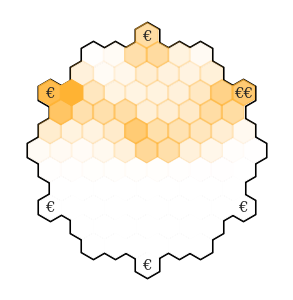

In [69]:
colors, map = sim_utils.get_sim_freq(path_movescsv=moves_path)
plots_utils.make_freq_plot(rgba_colors=colors, mapmap = map, plotname = 'sim_freqplot', output_path=output_path)

### Other plots

In [63]:
# get data
emp_df, emp_group_arrival = emp_utils.get_empdata_for_comparisons()
sim_df, sim_group_arrival = sim_utils.get_simdata_for_comparisons(evalcsv_path=eval_path, movecsv_path=moves_path)

# merge
df = plots_utils.merge_sim_emp_data_for_comparisons(sim_data = sim_df, emp_data = emp_df)

/content/hc-environment/gym_honeycomb/common/emp_utils.py:438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['reward'] = rewards
/content/hc-environment/gym_honeycomb/common/emp_utils.py:439: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['arrived'] = arriveds
/content/hc-environment/gym_honeycomb/common/emp_utils.py:438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


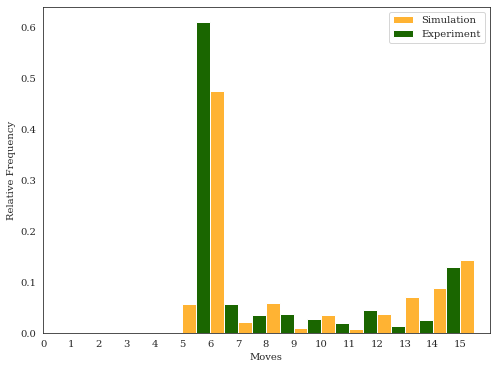

In [70]:
plots_utils.plot_amount_of_moves(df = df, output_path = output_path, plotname= 'relfrequencyplot')

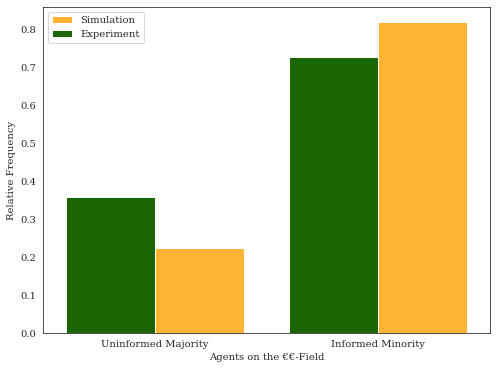

In [71]:
plots_utils.plot_arrived_special_payoff(df = df, output_path = output_path, plotname='relfrequencyofmoves') 

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


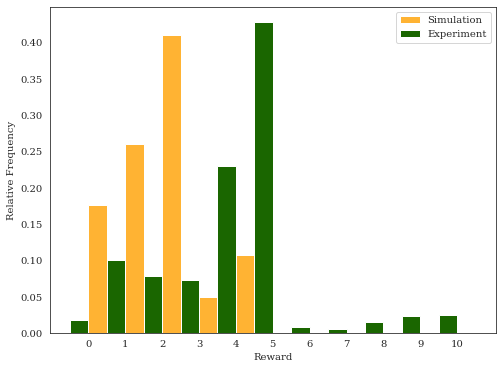

In [72]:
plots_utils.plot_freq_of_rewards(df = df, output_path = output_path, plotname='relfrequencyofrewards')

0


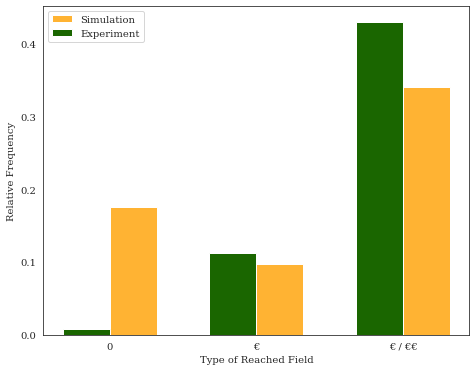

In [73]:
plots_utils.plot_rel_freq_type_of_field(df = df, output_path = output_path, plotname='relfrequencytypeoffield')

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


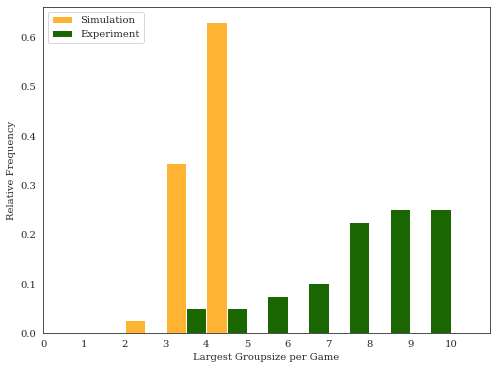

In [74]:
plots_utils.plot_freq_of_grouparrivalsizes(sim_group_arrival, emp_group_arrival, output_path=output_path, plotname='relfrequencyofgrouparrivalsizes')

# MA Simulation: Last saved model

Policy saved at 20e6 step

In [19]:
policy_dir_list = []
policy_seeds_maj = [518, 321, 7373, 601, 3639, 307, 4444, 12]
policy_seeds_min = [23456, 342]
for s in policy_seeds_maj:
  policy_dir_list.append('/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_' + str(s) + '.zip')

for s in policy_seeds_min:
  policy_dir_list.append('/content/drive/MyDrive/HC/SB_FINAL3/Min/min_step6000_oep5_mb200_' + str(s) + '.zip')

sim_nr = 200
print('Use policies with seeds:', policy_seeds_maj + policy_seeds_min)

Use policies with seeds: [518, 321, 7373, 601, 3639, 307, 4444, 12, 23456, 342]


In [20]:
policy_dir_list

['/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_518.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_321.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_7373.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_601.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_3639.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_307.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_4444.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_12.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Min/min_step6000_oep5_mb200_23456.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Min/min_step6000_oep5_mb200_342.zip']

In [21]:
ma_sim = SimpleSimulation()
df_move, df_eval, df_check = ma_sim.multi_agent_simulation(agents=policy_dir_list,
                                                      num_sim=5000, num_step=1000,
                                                      shuffle=True,
                                                      deterministic=False)


 ------------ Start MA Simulation ------------
Load agents...

 ------ Start 5000 Simulations ------
0 Games over! Average Reward= 11.0
100 Games over! Average Reward= 10.48019801980198
200 Games over! Average Reward= 10.965174129353233
300 Games over! Average Reward= 11.406976744186046
400 Games over! Average Reward= 11.361596009975063
500 Games over! Average Reward= 11.336327345309382
600 Games over! Average Reward= 11.387687188019967
700 Games over! Average Reward= 11.293152639087019
800 Games over! Average Reward= 11.247191011235955
900 Games over! Average Reward= 11.235294117647058
1000 Games over! Average Reward= 11.186313686313687
1100 Games over! Average Reward= 11.17983651226158
1200 Games over! Average Reward= 11.152373022481266
1300 Games over! Average Reward= 11.210991544965411
1400 Games over! Average Reward= 11.209850107066382
1500 Games over! Average Reward= 11.272485009993337
1600 Games over! Average Reward= 11.330730793254217
1700 Games over! Average Reward= 11.336566

## Check dataframes

### Check df

In [22]:
ma_sim.check_end_position

sim  agent      0      1      2  ...    69    70   71  72  73
end_position                                     ...                         
(0, 3)        14219  14219  14219  14219  14219  ...  3771  1660  389  10   5
(1, 1)          444    444    444    444    444  ...   109    48    7   1   1
(1, 2)         2258   2258   2258   2258   2258  ...   578   256   64   2   1
(1, 3)          249    249    249    249    249  ...    82    37   10   3   2
(1, 4)          432    432    432    432    432  ...   115    57   10   1   0
(1, 5)         3095   3095   3095   3095   3095  ...   891   393   72   0   0
(1, 6)           14     14     14     14     14  ...     9     4    1   0   0
(2, 1)          442    442    442    442    442  ...   110    42    7   0   0
(2, 2)          278    278    278    278    278  ...    76    26    7   0   0
(2, 3)          103    103    103    103    103  ...    41    23    6   0   0
(2, 4)           52     52     52     52     52  ...    26    19    5   0   0
(2, 5)           21     21     21     21     21  ...     9     5    1   0   0
(2, 6)           10     10     10     10     10  ...     3     1    0   0   0
(2, 7)            3      3      3      3      3  ...     1     0    0   0   0
(3, 0)         5102   5102   5102   5102   5102  ...  1286   565  133   4   2
(3, 1)          652    652    652    652    652  ...   162    62   17   0   0
(3, 2)          262    262    262    262    262  ...    60    23    4   0   0
(3, 3)          111    111    111    111    111  ...    45    22    4   0   0
(3, 4)           55     55     55     55     55  ...    25    13    3   1   0
(3, 5)           27     27     27     27     27  ...    16     7    2   0   0
(3, 6)           13     13     13     13     13  ...    10     4    1   0   0
(3, 7)            8      8      8      8      8  ...     4     4    2   0   0
(3, 8)            1      1      1      1      1  ...     1     0    0   0   0
(4, 1)          533    533    533    533    533  ...    88    35   10   1   1
(4, 2)          206    206    206    206    206  ...    57    29    7   0   0
(4, 3)          103    103    103    103    103  ...    48    28    9   0   0
(4, 4)           44     44     44     44     44  ...    24    14    3   0   0
(4, 5)           22     22     22     22     22  ...    10     6    3   0   0
(4, 6)           11     11     11     11     11  ...     4     2    0   0   0
(4, 7)            6      6      6      6      6  ...     3     3    2   0   0
(5, 1)          514    514    514    514    514  ...   116    51    7   0   0
(5, 2)          201    201    201    201    201  ...    59    26    3   0   0
(5, 3)           61     61     61     61     61  ...    18     8    3   0   0
(5, 4)           40     40     40     40     40  ...    13     5    1   1   0
(5, 5)           27     27     27     27     27  ...    13     8    1   0   0
(5, 6)           10     10     10     10     10  ...     6     1    1   0   0
(5, 7)            8      8      8      8      8  ...     5     3    1   0   0
(5, 8)            2      2      2      2      2  ...     0     0    0   0   0
(5, 10)           1      1      1      1      1  ...     1     1    0   0   0
(6, 1)           85     85     85     85     85  ...    24    11    2   0   0
(6, 2)          127    127    127    127    127  ...    30    11    2   0   0
(6, 3)           29     29     29     29     29  ...    10     4    0   0   0
(6, 4)           18     18     18     18     18  ...     8     3    1   0   0
(6, 5)           11     11     11     11     11  ...     5     4    0   0   0
(6, 6)            5      5      5      5      5  ...     2     0    0   0   0
(6, 7)            3      3      3      3      3  ...     0     0    0   0   0
(6, 8)            2      2      2      2      2  ...     1     0    0   0   0
(7, 2)          125    125    125    125    125  ...    38    15    7   1   1
(7, 3)           21     21     21     21     21  ...     8     6    2   0   0
(7, 4)            9      9      9     

### Eval df

In [23]:
ma_sim.eval_summary

sim           id  ...      arrivals         moves
count  50000.000000  50000.00000  ...  50000.000000  50000.000000
mean    2499.500000      4.50000  ...      2.844800      7.751460
std     1443.390078      2.87231  ...      0.794686      3.587878
min        0.000000      0.00000  ...      0.000000      5.000000
25%     1249.750000      2.00000  ...      2.000000      6.000000
50%     2499.500000      4.50000  ...      3.000000      6.000000
75%     3749.250000      7.00000  ...      3.000000      8.000000
max     4999.000000      9.00000  ...      5.000000     15.000000

[8 rows x 8 columns]

In [24]:
ma_sim.df_eval.groupby('moves').size()

moves
5      8635
6     26983
7       881
8      2811
9       160
10      588
11      163
12      306
13      297
14      441
15     8735
dtype: int64

In [25]:
print('%s agents have not arrived on a payoff field.' %ma_sim.df_eval[ma_sim.df_eval['reward']==0].shape[0])

16455 agents have not arrived on a payoff field.


### Move df

In [26]:
ma_sim.df_move.describe()

sim           turn  ...             s1             s2
count  387573.000000  387573.000000  ...  387573.000000  387573.000000
mean     2498.760778      75.048154  ...       5.428283       4.032505
std      1443.205856      99.629120  ...       2.868523       1.478253
min         0.000000       1.000000  ...       0.000000       0.000000
25%      1249.000000      20.000000  ...       3.000000       3.000000
50%      2498.000000      40.000000  ...       5.000000       4.000000
75%      3749.000000      77.000000  ...       8.000000       5.000000
max      4999.000000     600.000000  ...      11.000000      12.000000

[8 rows x 6 columns]

## Viz

In [27]:
output_path = '/content/drive/MyDrive/HC/Sim5000/last_saved_model'
ma_sim.save_results(path=output_path)

Saved dataframes in folder: /content/drive/MyDrive/HC/Sim5000/last_saved_model


In [28]:
# ANPASSEN
moves_path = output_path + '/sim_train_move.csv'
eval_path = output_path + '/sim_train_eval.csv'

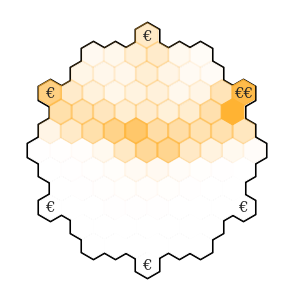

In [29]:
colors, map = sim_utils.get_sim_freq(path_movescsv=moves_path)
plots_utils.make_freq_plot(rgba_colors=colors, mapmap = map, plotname = 'sim_freqplot', output_path=output_path)

### Other plots

In [30]:
# get data
emp_df, emp_group_arrival = emp_utils.get_empdata_for_comparisons()
sim_df, sim_group_arrival = sim_utils.get_simdata_for_comparisons(evalcsv_path=eval_path, movecsv_path=moves_path)

# merge
df = plots_utils.merge_sim_emp_data_for_comparisons(sim_data = sim_df, emp_data = emp_df)

/content/hc-environment/gym_honeycomb/common/emp_utils.py:438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['reward'] = rewards
/content/hc-environment/gym_honeycomb/common/emp_utils.py:439: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['arrived'] = arriveds
/content/hc-environment/gym_honeycomb/common/emp_utils.py:438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


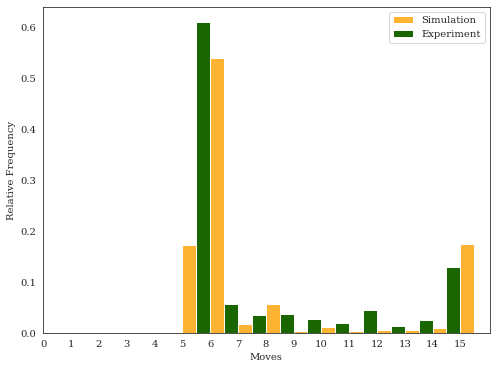

In [31]:
plots_utils.plot_amount_of_moves(df = df, output_path = output_path)

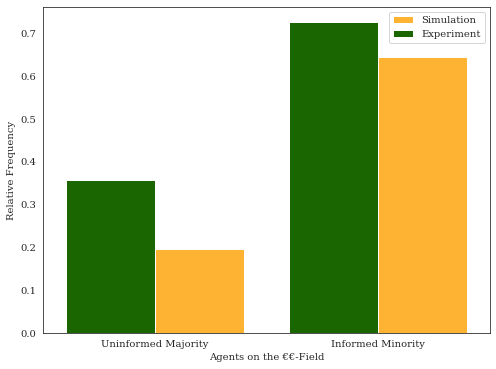

In [32]:
plots_utils.plot_arrived_special_payoff(df = df, output_path = output_path) 

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


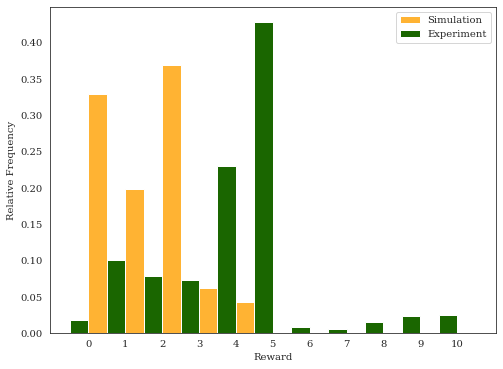

In [33]:
plots_utils.plot_freq_of_rewards(df = df, output_path = output_path)

0


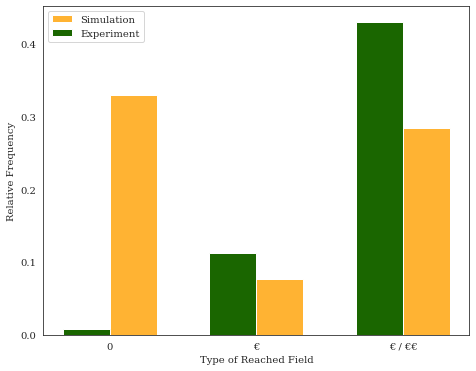

In [34]:
plots_utils.plot_rel_freq_type_of_field(df = df, output_path = output_path)

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


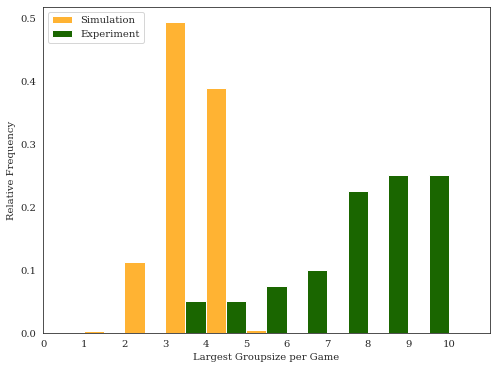

In [35]:
plots_utils.plot_freq_of_grouparrivalsizes(sim_group_arrival, emp_group_arrival, output_path=output_path)

# Choose policy randomly

Custom policy directory

In [ ]:
policy_seeds_maj = [518, 321, 7373, 601, 3639, 307, 4444, 12]
policy_seeds_min = [23456, 342]

numpy.random.seed(202) #2021

maj_policies = []
for seed in policy_seeds_maj:
  policy_list = []
  for file in os.listdir('/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_' + str(seed)):
     if file.endswith('.zip'): 
      policy_list.append('/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_' + str(seed) + '/' + file)
  
  rand_policy = random.sample(policy_list, k=1)
  maj_policies.append(rand_policy[0])
maj_policies

min_policies = []
for seed in policy_seeds_min:
  policy_list = []
  for file in os.listdir('/content/drive/MyDrive/HC/SB_FINAL3/Min/min_step6000_oep5_mb200_' + str(seed)):
     if file.endswith('.zip'): 
      policy_list.append('/content/drive/MyDrive/HC/SB_FINAL3/Min/min_step6000_oep5_mb200_' + str(seed) + '/' + file)
  
  rand_policy = random.sample(policy_list, k=1)
  min_policies.append(rand_policy[0])

policy_dir_list = maj_policies + min_policies
policy_dir_list

['/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_518/best_model_st10400000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_321/best_model_st10400000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_7373/best_model_st22400000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_601/best_model_st6400000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_3639/best_model_st4800000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_307/best_model_st6400000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_4444/best_model_st13600000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Maj/maj_step6000_oep5_mb200_12/best_model_st8000000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Min/min_step6000_oep5_mb200_23456/best_model_st24800000.zip',
 '/content/drive/MyDrive/HC/SB_FINAL3/Min/min_step6000_oep5_mb200_342/best_model_st21600000.zip']

In [ ]:
ma_sim = SimpleSimulation()
df_move, df_eval, df_check = ma_sim.multi_agent_simulation(agents=policy_dir_list,
                                                      num_sim=1000, num_step=600,
                                                      shuffle=False,
                                                      deterministic=False)


 ------------ Start MA Simulation ------------
Load agents...

 ------ Start 1000 Simulations ------
0 Games over! Average Reward= 9.5
100 Games over! Average Reward= 7.242574257425742
200 Games over! Average Reward= 7.293532338308458
300 Games over! Average Reward= 7.28405315614618
400 Games over! Average Reward= 7.43142144638404
500 Games over! Average Reward= 7.466067864271457
600 Games over! Average Reward= 7.554076539101498
700 Games over! Average Reward= 7.6255349500713265
800 Games over! Average Reward= 7.601747815230961
900 Games over! Average Reward= 7.553829078801332
------------ End MA Simulation ------------

Average Simulation Reward: 7.5885 

-------------------------------------------



## Check dataframes

### Check df

In [ ]:
ma_sim.check_end_position

sim  agent     0     1     2     3  ...  116  117  118  119  120  121
end_position                                       ...                              
(0, 3)        1707   1707  1707  1707  1707  1707  ...    3    1    1    1    1    1
(1, 1)          96     96    96    96    96    96  ...    0    0    0    0    0    0
(1, 2)         725    725   725   725   725   725  ...    1    1    0    0    0    0
(1, 3)         729    729   729   729   729   729  ...    3    2    1    1    1    1
(1, 4)         327    327   327   327   327   327  ...    5    3    2    2    2    2
(1, 5)         101    101   101   101   101   101  ...    1    1    0    0    0    0
(1, 6)           6      6     6     6     6     6  ...    0    0    0    0    0    0
(2, 1)          16     16    16    16    16    16  ...    0    0    0    0    0    0
(2, 2)          66     66    66    66    66    66  ...    1    0    0    0    0    0
(2, 3)          93     93    93    93    93    93  ...    1    0    0    0    0    0
(2, 4)          59     59    59    59    59    59  ...    0    0    0    0    0    0
(2, 5)          45     45    45    45    45    45  ...    0    0    0    0    0    0
(2, 6)          10     10    10    10    10    10  ...    0    0    0    0    0    0
(3, 0)        1908   1908  1908  1908  1908  1908  ...    7    3    1    1    1    1
(3, 1)          15     15    15    15    15    15  ...    0    0    0    0    0    0
(3, 2)           3      3     3     3     3     3  ...    0    0    0    0    0    0
(3, 3)           6      6     6     6     6     6  ...    0    0    0    0    0    0
(3, 4)           8      8     8     8     8     8  ...    1    0    0    0    0    0
(3, 5)           4      4     4     4     4     4  ...    0    0    0    0    0    0
(3, 6)           1      1     1     1     1     1  ...    0    0    0    0    0    0
(4, 1)           3      3     3     3     3     3  ...    1    1    1    1    1    1
(4, 5)           1      1     1     1     1     1  ...    0    0    0    0    0    0
(4, 7)           1      1     1     1     1     1  ...    0    0    0    0    0    0
(5, 1)          70     70    70    70    70    70  ...    0    0    0    0    0    0
(6, 2)           1      1     1     1     1     1  ...    0    0    0    0    0    0
(6, 3)           1      1     1     1     1     1  ...    0    0    0    0    0    0
(7, 2)          31     31    31    31    31    31  ...    0    0    0    0    0    0
(7, 3)          48     48    48    48    48    48  ...    0    0    0    0    0    0
(7, 4)           5      5     5     5     5     5  ...    0    0    0    0    0    0
(8, 3)         564    564   564   564   564   564  ...    5    2    1    1    1    1
(8, 4)          99     99    99    99    99    99  ...    0    0    0    0    0    0
(8, 5)          11     11    11    11    11    11  ...    0    0    0    0    0    0
(9, 3)        2021   2021  2021  2021  2021  2021  ...    6    4    3    3    3    3
(9, 4)         624    624   624   624   624   624  ...    3    1    0    0    0    0
(9, 5)          72     72    72    72    72    72  ...    0    0    0    0    0    0
(9, 6)           5      5     5     5     5     5  ...    0    0    0    0    0    0
(10, 5)        468    468   468   468   468   468  ...    2    1    0    0    0    0
(10, 6)         34     34    34    34    34    34  ...    0    0    0    0    0    0
(11, 6)         16     16    16    16    16    16  ...    0    0    0    0    0    0

[39 rows x 124 columns]

In [ ]:
#agent_end = ma_sim.df_check.groupby(['agent', 'end_position']).count()
#agent_end

In [ ]:
ma_sim.df_check[ma_sim.df_check['sim']==0]

sim  agent       0       1       2       3  ...  116  117  118  119  120  121
0    0      0  (6, 6)  (5, 5)  (4, 4)  (3, 3)  ...  NaN  NaN  NaN  NaN  NaN  NaN
1    0      1  (6, 6)  (6, 5)  (6, 4)  (5, 3)  ...  NaN  NaN  NaN  NaN  NaN  NaN
2    0      2  (6, 6)  (5, 5)  (4, 5)  (3, 4)  ...  NaN  NaN  NaN  NaN  NaN  NaN
3    0      3  (6, 6)  (5, 5)  (4, 5)  (3, 5)  ...  NaN  NaN  NaN  NaN  NaN  NaN
4    0      4  (6, 6)  (7, 6)  (8, 6)  (8, 5)  ...  NaN  NaN  NaN  NaN  NaN  NaN
5    0      5  (6, 6)  (5, 5)  (6, 5)  (6, 4)  ...  NaN  NaN  NaN  NaN  NaN  NaN
6    0      6  (6, 6)  (6, 5)  (5, 4)  (4, 3)  ...  NaN  NaN  NaN  NaN  NaN  NaN
7    0      7  (6, 6)  (5, 5)  (4, 4)  (4, 4)  ...  NaN  NaN  NaN  NaN  NaN  NaN
8    0      8  (6, 6)  (7, 6)  (8, 6)  (9, 6)  ...  NaN  NaN  NaN  NaN  NaN  NaN
9    0      9  (6, 6)  (6, 5)  (6, 4)  (7, 4)  ...  NaN  NaN  NaN  NaN  NaN  NaN

[10 rows x 125 columns]

In [ ]:
# Which simulation have the longest turn count?
#bools = ma_sim.df_check[555].isna()
#ma_sim.df_check[-bools]['sim'].unique()

### Eval df

In [ ]:
ma_sim.eval_summary

sim            id  ...      arrivals         moves
count  10000.000000  10000.000000  ...  10000.000000  10000.000000
mean     499.500000      4.500000  ...      2.021000     11.793400
std      288.689425      2.872425  ...      0.913588      3.836403
min        0.000000      0.000000  ...      0.000000      5.000000
25%      249.750000      2.000000  ...      1.000000      7.000000
50%      499.500000      4.500000  ...      2.000000     14.000000
75%      749.250000      7.000000  ...      3.000000     15.000000
max      999.000000      9.000000  ...      4.000000     15.000000

[8 rows x 8 columns]

In [ ]:
ma_sim.df_eval.groupby('moves').size()

moves
5      153
6     2303
7       87
8      522
9       71
10     139
11     145
12     534
13     843
14     470
15    4733
dtype: int64

In [ ]:
ma_sim.df_eval.head()

sim  id  informed  reward  remaining moves  arrived  arrivals  moves
0    0   0         0     0.0                0        0         2     15
1    0   1         0     1.0                7        0         2      8
2    0   2         0     1.5                9        0         2      6
3    0   3         0     1.5                7        0         2      8
4    0   4         0     1.0                0        1         2     15

In [ ]:
print('%s agents have not arrived on a payoff field.' %ma_sim.df_eval[ma_sim.df_eval['reward']==0].shape[0])

4364 agents have not arrived on a payoff field.


### Move df

In [ ]:
ma_sim.df_move.describe()

sim           turn  ...             s1             s2
count  117934.000000  117934.000000  ...  117934.000000  117934.000000
mean      499.312649     105.096164  ...       4.751895       3.563179
std       288.733359     110.365143  ...       2.961473       1.459108
min         0.000000       1.000000  ...       0.000000       0.000000
25%       249.000000      31.000000  ...       2.000000       3.000000
50%       499.000000      66.000000  ...       5.000000       4.000000
75%       749.000000     137.000000  ...       7.000000       5.000000
max       999.000000     600.000000  ...      11.000000       9.000000

[8 rows x 6 columns]

## Viz

In [ ]:
ma_sim.save_results(path='/content/drive/MyDrive/HC/VergleicheSim/random_sim1000')

Saved dataframes in folder: /content/drive/MyDrive/HC/VergleicheSim/random_sim1000


In [ ]:
# ANPASSEN
moves_path = '/content/drive/MyDrive/HC/VergleicheSim/random_sim1000/sim_train_move.csv'
eval_path = '/content/drive/MyDrive/HC/VergleicheSim/random_sim1000/sim_train_eval.csv'

output_path = '/content/drive/MyDrive/HC/VergleicheSim/random_sim1000/'

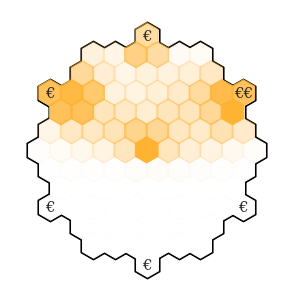

In [ ]:
colors, map = sim_utils.get_sim_freq(path_movescsv=moves_path)
plots_utils.make_freq_plot(rgba_colors=colors, mapmap = map, plotname = 'sim_freqplot_random_sim1000', output_path=output_path)

### Other plots

In [ ]:
# get data
emp_df, emp_group_arrival = emp_utils.get_empdata_for_comparisons()
sim_df, sim_group_arrival = sim_utils.get_simdata_for_comparisons(evalcsv_path=eval_path, movecsv_path=moves_path)

# merge
df = plots_utils.merge_sim_emp_data_for_comparisons(sim_data = sim_df, emp_data = emp_df)

/content/hc-environment/gym_honeycomb/common/emp_utils.py:410: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['reward'] = rewards
/content/hc-environment/gym_honeycomb/common/emp_utils.py:411: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['arrived'] = arriveds
/content/hc-environment/gym_honeycomb/common/emp_utils.py:410: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


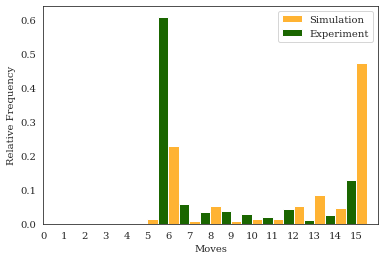

In [ ]:
plots_utils.plot_amount_of_moves(df = df, output_path = output_path)

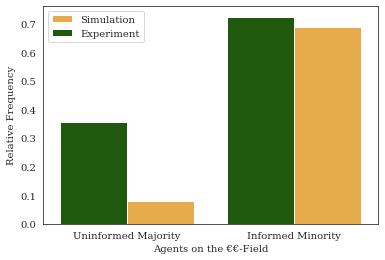

In [ ]:
plots_utils.plot_arrived_special_payoff(df = df, output_path = output_path) 

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


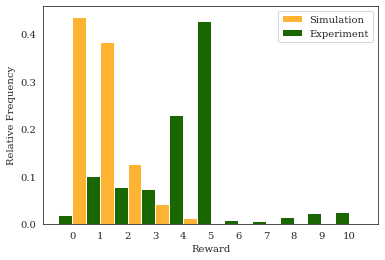

In [ ]:
plots_utils.plot_freq_of_rewards(df = df, output_path = output_path)

0


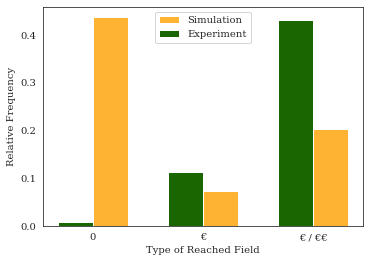

In [ ]:
plots_utils.plot_rel_freq_type_of_field(df = df, output_path = output_path)

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


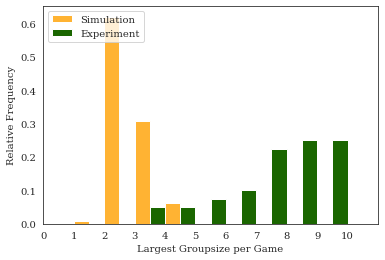

<Figure size 432x288 with 0 Axes>

In [ ]:
plots_utils.plot_freq_of_grouparrivalsizes(sim_group_arrival, emp_group_arrival)